In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import RobustScaler
import seaborn as sns
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.metrics import classification_report, accuracy_score, f1_score
import itertools

In [2]:
file_path = r"C:\Users\jens.nilsen\OneDrive - Bouvet Norge AS\Documents\GitHub\trfkaipoc\data_2022-2025.csv"
df = pd.read_csv(file_path, sep=";")

In [3]:
df = df[df["EGS.VEDTAK.10670"].notna()]

In [4]:
df['Avslag_ind'] = df['EGS.VEDTAK.10670'].apply(lambda x: 1 if x == "Avslag" else 0)

In [5]:
andel_avslag=df['Avslag_ind'].sum()/df['Avslag_ind'].count()

In [6]:
andel_avslag

0.0405982905982906

In [7]:
antall_avslag=df['Avslag_ind'].sum()

In [8]:
antall_avslag

19

In [9]:
features = [
    'Avslag_ind',
    "ÅDT, total",
    "ÅDT, andel lange kjøretøy",
    "Fartsgrense",
    "Avkjørsel, holdningsklasse",
    "Funksjonsklasse",
    "Avkjørsler",
    "Trafikkulykker",
    "EGS.BRUKSOMRÅDE.1256", 
    "Kurvatur, horisontal", 
    "Kurvatur, stigning"
]

# Encode categorical features
df_encoded = pd.get_dummies(df[features])

In [10]:
df_encoded=df_encoded.dropna()

In [11]:
df_encoded['sving_ind'] = np.where(df_encoded['Kurvatur, horisontal'].abs() > 99000, 0, 1)

In [12]:
df_encoded['sving'] = np.where(df_encoded['Kurvatur, horisontal'].abs() < 99000, df_encoded['Kurvatur, horisontal'].abs(), 0)

In [13]:
df_encoded['bakke_ind'] = np.where(df_encoded['Kurvatur, stigning'].abs() > 0.1, 1, 0)

In [14]:
df_encoded['sving_sigmoid'] = np.where(df_encoded['Kurvatur, horisontal'].abs() < 99000, 1/(1+np.exp(-0.001*df_encoded['Kurvatur, horisontal'].abs())), 0)

In [15]:
df_encoded['bakke']=df_encoded['Kurvatur, stigning'].abs()

In [16]:
df_encoded['bakke_sigmoid'] = 1/(1+np.exp(-0.001*df_encoded['Kurvatur, horisontal'].abs()))

In [17]:
df_encoded['antall_lange_kj']=df_encoded['ÅDT, total']*df_encoded['ÅDT, andel lange kjøretøy']/100

In [18]:
df_encoded = df_encoded.drop(['Kurvatur, horisontal', 'Kurvatur, stigning'], axis=1)

In [19]:
y = df_encoded['Avslag_ind']        # target
X = df_encoded.drop(columns=['Avslag_ind'])  # all other columns

In [20]:
X

,"ÅDT, total","ÅDT, andel lange kjøretøy",Fartsgrense,Avkjørsler,Trafikkulykker,"Avkjørsel, holdningsklasse_Lite streng","Avkjørsel, holdningsklasse_Meget streng","Avkjørsel, holdningsklasse_Mindre streng","Avkjørsel, holdningsklasse_Streng",Funksjonsklasse_B - Regionale hovedveger,...,EGS.BRUKSOMRÅDE.1256_Service,EGS.BRUKSOMRÅDE.1256_Skog/skogbruk,EGS.BRUKSOMRÅDE.1256_Skole/Barnehage,sving_ind,sving,bakke_ind,sving_sigmoid,bakke,bakke_sigmoid,antall_lange_kj
0,550.0,11.0,80.0,11,1,True,False,False,False,False,...,False,False,False,1,405.0,1,0.599888,0.5,0.599888,60.50
1,293.0,7.0,60.0,8,1,True,False,False,False,False,...,False,False,False,1,415.0,1,0.602286,1.0,0.602286,20.51
2,1500.0,13.0,80.0,2,4,False,False,False,True,False,...,False,False,False,1,182.0,1,0.545375,0.7,0.545375,195.00
3,15000.0,6.0,50.0,9,50,False,False,False,True,True,...,False,False,False,0,0.0,1,0.000000,0.3,1.000000,900.00
4,2980.0,12.0,80.0,5,8,False,False,False,True,False,...,False,False,False,0,0.0,1,0.000000,2.4,1.000000,357.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463,1300.0,6.0,30.0,21,0,True,False,False,False,False,...,False,False,False,1,1520.0,1,0.820538,0.5,0.820538,78.00
464,500.0,10.0,60.0,12,2,False,False,True,False,False,...,False,False,False,1,1119.0,1,0.753803,0.2,0.753803,50.00
465,400.0,13.0,60.0,12,0,False,False,False,True,False,...,False,False,False,1,192.0,1,0.547853,5.5,0.547853,52.00
466,1600.0,15.0,80.0,8,6,False,False,False,True,True,...,False,True,False,1,524.0,1,0.628083,3.0,0.628083,240.00


In [21]:
poly = PolynomialFeatures(3, include_bias=False, interaction_only=True) 
X = pd.DataFrame(
    poly.fit_transform(X),
    columns=poly.get_feature_names_out(X.columns)
)

In [22]:
X

,"ÅDT, total","ÅDT, andel lange kjøretøy",Fartsgrense,Avkjørsler,Trafikkulykker,"Avkjørsel, holdningsklasse_Lite streng","Avkjørsel, holdningsklasse_Meget streng","Avkjørsel, holdningsklasse_Mindre streng","Avkjørsel, holdningsklasse_Streng",Funksjonsklasse_B - Regionale hovedveger,...,bakke_ind sving_sigmoid bakke,bakke_ind sving_sigmoid bakke_sigmoid,bakke_ind sving_sigmoid antall_lange_kj,bakke_ind bakke bakke_sigmoid,bakke_ind bakke antall_lange_kj,bakke_ind bakke_sigmoid antall_lange_kj,sving_sigmoid bakke bakke_sigmoid,sving_sigmoid bakke antall_lange_kj,sving_sigmoid bakke_sigmoid antall_lange_kj,bakke bakke_sigmoid antall_lange_kj
0,550.0,11.0,80.0,11.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.299944,0.359866,36.293246,0.299944,30.25,36.293246,0.179933,18.146623,21.771896,18.146623
1,293.0,7.0,60.0,8.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.602286,0.362749,12.352889,0.602286,20.51,12.352889,0.362749,12.352889,7.439975,12.352889
2,1500.0,13.0,80.0,2.0,4.0,0.0,0.0,0.0,1.0,0.0,...,0.381762,0.297434,106.348090,0.381762,136.50,106.348090,0.208204,74.443663,57.999570,74.443663
3,15000.0,6.0,50.0,9.0,50.0,0.0,0.0,0.0,1.0,1.0,...,0.000000,0.000000,0.000000,0.300000,270.00,900.000000,0.000000,0.000000,0.000000,270.000000
4,2980.0,12.0,80.0,5.0,8.0,0.0,0.0,0.0,1.0,0.0,...,0.000000,0.000000,0.000000,2.400000,858.24,357.600000,0.000000,0.000000,0.000000,858.240000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
451,1300.0,6.0,30.0,21.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.410269,0.673283,64.002001,0.410269,39.00,64.002001,0.336642,32.001001,52.516105,32.001001
452,500.0,10.0,60.0,12.0,2.0,0.0,0.0,1.0,0.0,0.0,...,0.150761,0.568219,37.690159,0.150761,10.00,37.690159,0.113644,7.538032,28.410962,7.538032
453,400.0,13.0,60.0,12.0,0.0,0.0,0.0,0.0,1.0,0.0,...,3.013192,0.300143,28.488360,3.013192,286.00,28.488360,1.650787,156.685982,15.607436,156.685982
454,1600.0,15.0,80.0,8.0,6.0,0.0,0.0,0.0,1.0,1.0,...,1.884248,0.394488,150.739830,1.884248,720.00,150.739830,1.183463,452.219489,94.677068,452.219489


In [23]:
andel_avslag=y.sum()/y.count()

In [24]:
#X=df_with_interactions
scaler = PowerTransformer()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [25]:
# Identify binary dummy columns: only {0,1} or {0.0,1.0}
binary_cols = [
    col for col in X.columns
    if np.isin(X[col].dropna().unique(), [0,1]).all()
]

continuous_cols = [col for col in X.columns if col not in binary_cols]

# Transform only continuous columns
scaler = PowerTransformer()
X_cont_scaled = pd.DataFrame(
    scaler.fit_transform(X[continuous_cols]),
    columns=continuous_cols,
    index=X.index
)

# Combine back into full feature matrix
X = pd.concat([X_cont_scaled, X[binary_cols]], axis=1)

In [26]:
X

,"ÅDT, total","ÅDT, andel lange kjøretøy",Fartsgrense,Avkjørsler,Trafikkulykker,"Avkjørsel, holdningsklasse_Lite streng","Avkjørsel, holdningsklasse_Meget streng","Avkjørsel, holdningsklasse_Mindre streng","Avkjørsel, holdningsklasse_Streng",Funksjonsklasse_B - Regionale hovedveger,...,EGS.BRUKSOMRÅDE.1256_Service EGS.BRUKSOMRÅDE.1256_Skole/Barnehage bakke,EGS.BRUKSOMRÅDE.1256_Service EGS.BRUKSOMRÅDE.1256_Skole/Barnehage bakke_sigmoid,EGS.BRUKSOMRÅDE.1256_Service EGS.BRUKSOMRÅDE.1256_Skole/Barnehage antall_lange_kj,EGS.BRUKSOMRÅDE.1256_Skog/skogbruk EGS.BRUKSOMRÅDE.1256_Skole/Barnehage sving_ind,EGS.BRUKSOMRÅDE.1256_Skog/skogbruk EGS.BRUKSOMRÅDE.1256_Skole/Barnehage sving,EGS.BRUKSOMRÅDE.1256_Skog/skogbruk EGS.BRUKSOMRÅDE.1256_Skole/Barnehage bakke_ind,EGS.BRUKSOMRÅDE.1256_Skog/skogbruk EGS.BRUKSOMRÅDE.1256_Skole/Barnehage sving_sigmoid,EGS.BRUKSOMRÅDE.1256_Skog/skogbruk EGS.BRUKSOMRÅDE.1256_Skole/Barnehage bakke,EGS.BRUKSOMRÅDE.1256_Skog/skogbruk EGS.BRUKSOMRÅDE.1256_Skole/Barnehage bakke_sigmoid,EGS.BRUKSOMRÅDE.1256_Skog/skogbruk EGS.BRUKSOMRÅDE.1256_Skole/Barnehage antall_lange_kj
0,0.010865,0.134292,1.103247,0.278445,0.288650,1.077561,-0.105292,-0.546942,-0.641689,-0.478655,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.613946,-1.010401,-0.429223,-0.257664,0.288650,1.077561,-0.105292,-0.546942,-0.641689,-0.478655,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.917971,0.544549,1.103247,-1.753731,1.123085,-0.928022,-0.105292,-0.546942,1.558387,-0.478655,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2.657241,-1.408749,-1.030459,-0.069686,1.810715,-0.928022,-0.105292,-0.546942,1.558387,2.089188,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.482774,0.348960,1.103247,-0.900460,1.414272,-0.928022,-0.105292,-0.546942,1.558387,-0.478655,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
451,0.794752,-1.408749,-1.969334,1.675088,-1.063441,1.077561,-0.105292,-0.546942,-0.641689,-0.478655,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
452,-0.080838,-0.103228,-0.429223,0.440963,0.737980,-0.928022,-0.105292,1.828348,-0.641689,-0.478655,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
453,-0.299520,0.544549,-0.429223,0.440963,-1.063441,-0.928022,-0.105292,-0.546942,1.558387,-0.478655,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
454,0.972907,0.889551,1.103247,-0.257664,1.305058,-0.928022,-0.105292,-0.546942,1.558387,2.089188,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
model = RandomForestClassifier(
    n_estimators=1000,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
model.fit(X, y)

# Get feature importances
importances = pd.Series(model.feature_importances_, index=X.columns)
importances_sorted = importances.sort_values(ascending=False)
importances
# Select top 10 features
top_features = importances_sorted.index[:15]
X_top = X[top_features]

In [28]:
importances_sorted

Avkjørsler bakke antall_lange_kj                                                             0.005918
ÅDT, total bakke_sigmoid antall_lange_kj                                                     0.005031
Fartsgrense Avkjørsler bakke_sigmoid                                                         0.004458
Fartsgrense Avkjørsler                                                                       0.004261
ÅDT, andel lange kjøretøy bakke_ind bakke_sigmoid                                            0.004254
                                                                                               ...   
Fartsgrense Funksjonsklasse_C - Lokale hovedveger Funksjonsklasse_E - Lokale adkomstveger    0.000000
Fartsgrense Funksjonsklasse_C - Lokale hovedveger EGS.BRUKSOMRÅDE.1256_Forretning            0.000000
Fartsgrense Funksjonsklasse_C - Lokale hovedveger EGS.BRUKSOMRÅDE.1256_Fritidsaktivitet      0.000000
Fartsgrense Funksjonsklasse_C - Lokale hovedveger EGS.BRUKSOMRÅDE.1256_Naust      

In [29]:
X=X_top

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [31]:
X_train_orig=X_train
y_train_orig=y_train

In [32]:
smote = ADASYN(sampling_strategy=0.3, random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [33]:
# Fit logistic regression
model = LogisticRegression(max_iter=10000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=10000)

In [34]:
yps=model.predict_proba(X_test)

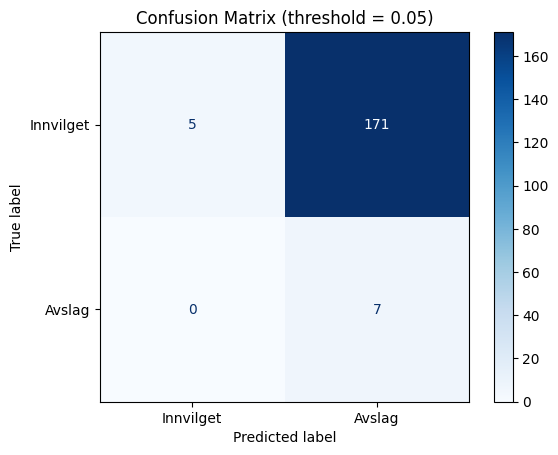

In [35]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Predicted probabilities for class "1"
y_prob = yps[:, 1]

# Adjustable threshold
threshold = 0.05 # 👈 change this value between 0 and 1

# Convert probabilities to class predictions
y_pred = (y_prob >= threshold).astype(int)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Innvilget", "Avslag"])

# Plot
disp.plot(cmap="Blues")
plt.title(f"Confusion Matrix (threshold = {threshold})")
plt.show()

In [36]:
# Detailed metrics per class
print("Classification Report Logistic regression:")
print(classification_report(y_test, y_pred, digits=4))

Classification Report Logistic regression:
              precision    recall  f1-score   support

           0     1.0000    0.0284    0.0552       176
           1     0.0393    1.0000    0.0757         7

    accuracy                         0.0656       183
   macro avg     0.5197    0.5142    0.0655       183
weighted avg     0.9633    0.0656    0.0560       183



In [37]:
model = RandomForestClassifier(n_estimators=5000,n_jobs=-1)
model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=5000, n_jobs=-1)

In [38]:
yps=model.predict_proba(X_test)

In [39]:
X_test

,Avkjørsler bakke antall_lange_kj,"ÅDT, total bakke_sigmoid antall_lange_kj",Fartsgrense Avkjørsler bakke_sigmoid,Fartsgrense Avkjørsler,"ÅDT, andel lange kjøretøy bakke_ind bakke_sigmoid",Fartsgrense bakke,"ÅDT, total Avkjørsler bakke","ÅDT, andel lange kjøretøy Avkjørsler bakke_sigmoid","ÅDT, total Avkjørsler antall_lange_kj","ÅDT, andel lange kjøretøy bakke antall_lange_kj",Avkjørsler antall_lange_kj,"ÅDT, total",Avkjørsler bakke_sigmoid,"ÅDT, total ÅDT, andel lange kjøretøy Fartsgrense","ÅDT, total antall_lange_kj"
373,-0.251555,-0.032849,0.856146,0.395869,0.306506,-0.110696,-0.168786,0.116887,-0.173537,-0.391011,-0.212562,-0.080838,0.367405,-0.028619,-0.167868
39,-0.203903,-0.884220,-0.391455,-0.292992,-0.492100,0.136762,0.003924,-0.467745,-0.643869,-0.525980,-0.692714,-0.613946,-0.030892,-1.266509,-0.844388
340,1.009797,0.755401,-0.062201,0.184924,-0.386206,0.136762,1.137731,-0.065958,0.886094,0.554450,0.856117,0.923645,0.314408,0.457471,0.815624
218,0.716074,1.191298,0.149862,1.047489,-0.197972,-0.977781,0.591556,0.623876,1.681013,0.296448,1.956721,1.274645,0.529860,1.207825,1.356423
155,0.267769,-0.332814,1.514314,1.074591,0.472071,0.710452,0.272967,0.635409,-0.301057,0.028996,-0.185816,-0.433056,0.866742,-0.270019,-0.473947
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,0.608898,-0.930432,1.717602,1.288238,1.198948,1.706644,0.362151,1.365685,-0.712439,0.565319,-0.401256,-1.256557,1.015551,-0.638648,-1.083889
193,0.402944,0.034620,-0.211572,-0.129249,-0.018328,0.069217,0.402197,0.086436,0.101019,0.212838,0.155136,0.093699,0.159427,-0.203404,0.062246
351,0.042113,0.751203,0.298197,-0.161607,0.306506,-0.523166,0.113635,0.116887,0.534831,-0.093018,0.432746,0.695229,0.367405,0.491167,0.631056
399,-1.246618,-0.334789,-0.193408,-0.637393,1.811432,-1.197925,-1.367891,0.387351,-0.638247,-0.833542,-0.565408,-0.791111,-0.491867,0.060082,-0.475962


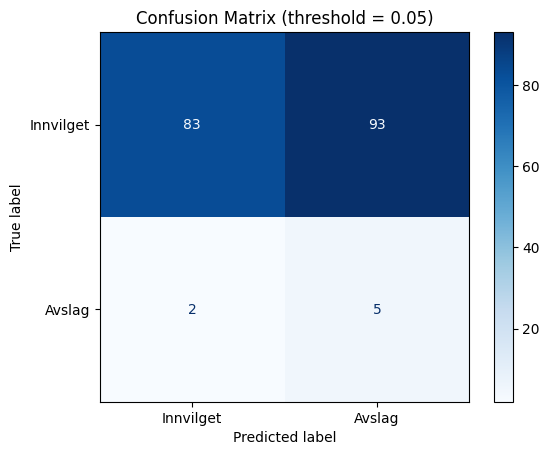

In [40]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Predicted probabilities for class "1"
y_prob = yps[:, 1]

# Adjustable threshold
threshold = 0.05 # 👈 change this value between 0 and 1

# Convert probabilities to class predictions
y_pred = (y_prob >= threshold).astype(int)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Innvilget", "Avslag"])

# Plot
disp.plot(cmap="Blues")
plt.title(f"Confusion Matrix (threshold = {threshold})")
plt.show()

In [41]:
# Detailed metrics per class
print("Classification Report Random Forrest:")
print(classification_report(y_test, y_pred, digits=4))

Classification Report Random Forrest:
              precision    recall  f1-score   support

           0     0.9765    0.4716    0.6360       176
           1     0.0510    0.7143    0.0952         7

    accuracy                         0.4809       183
   macro avg     0.5137    0.5929    0.3656       183
weighted avg     0.9411    0.4809    0.6153       183



In [42]:
importances = pd.Series(model.feature_importances_, index=X_train.columns)
importances_sorted = importances.sort_values(ascending=False)

In [43]:
print(importances_sorted)

Fartsgrense Avkjørsler bakke_sigmoid                  0.096658
ÅDT, andel lange kjøretøy bakke_ind bakke_sigmoid     0.093067
Avkjørsler bakke_sigmoid                              0.082669
ÅDT, andel lange kjøretøy Avkjørsler bakke_sigmoid    0.080443
ÅDT, total ÅDT, andel lange kjøretøy Fartsgrense      0.072038
ÅDT, total Avkjørsler bakke                           0.068206
ÅDT, total bakke_sigmoid antall_lange_kj              0.067138
ÅDT, total antall_lange_kj                            0.063487
Avkjørsler bakke antall_lange_kj                      0.062820
Fartsgrense Avkjørsler                                0.062090
ÅDT, total                                            0.060404
ÅDT, total Avkjørsler antall_lange_kj                 0.057680
Fartsgrense bakke                                     0.051530
Avkjørsler antall_lange_kj                            0.045272
ÅDT, andel lange kjøretøy bakke antall_lange_kj       0.036499
dtype: float64


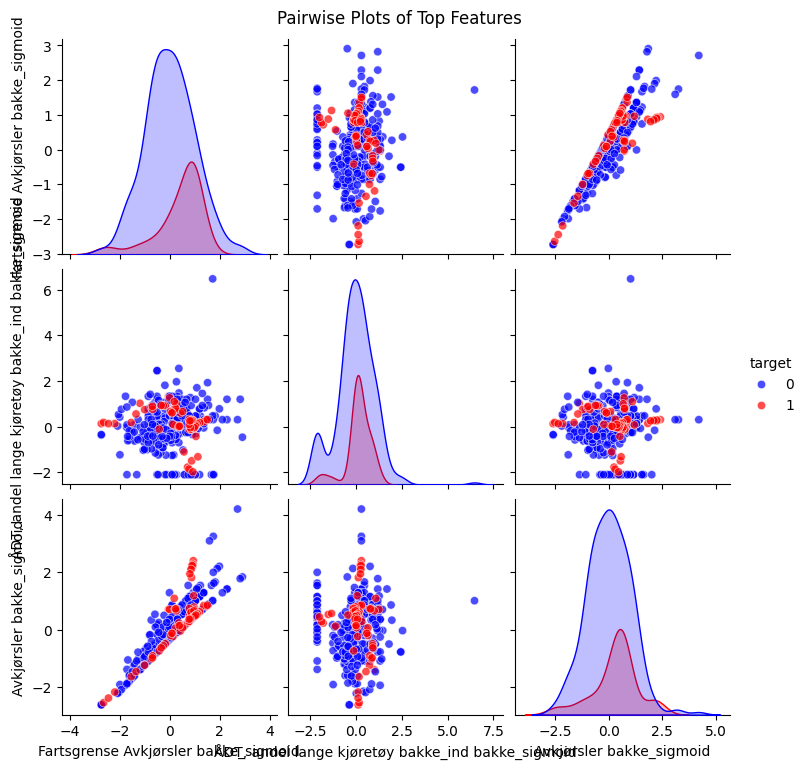

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

# Get the top 4 features
top_features = importances_sorted.index[:3]

# Subset data
X_top = X_train[top_features].copy()
X_top['target'] = y_train  # add the target

# Pairwise scatter plots
sns.pairplot(
    X_top,
    vars=top_features,
    hue='target',            # color by target
    palette={0: "blue", 1: "red"}, 
    plot_kws={'alpha': 0.7}
)
plt.suptitle("Pairwise Plots of Top Features", y=1.02)
plt.show()

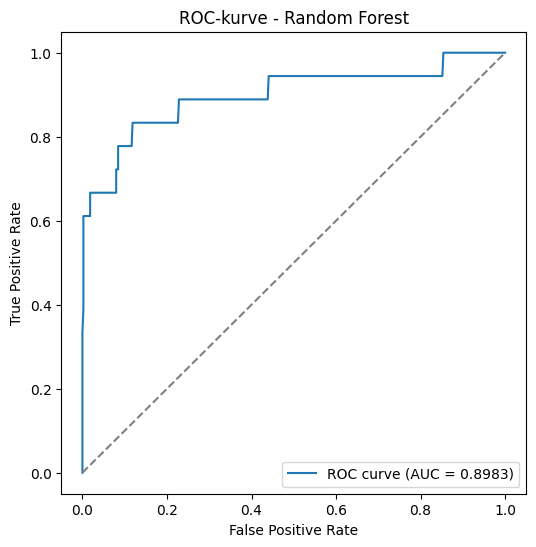

In [45]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Sannsynligheter for den positive klassen
y_proba = model.predict_proba(X)[:, 1]

# Beregn ROC-verdier
fpr, tpr, thresholds = roc_curve(y, y_proba)
auc = roc_auc_score(y, y_proba)

# Plott ROC-kurve
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.4f})')
plt.plot([0,1], [0,1], linestyle='--', color='gray')  # baseline
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-kurve - Random Forest')
plt.legend(loc='lower right')
plt.show()

In [46]:
#Kort sagt: hver x-verdi viser hvor mange negative som blir feil, hver y-verdi viser hvor mange positive som blir riktig.

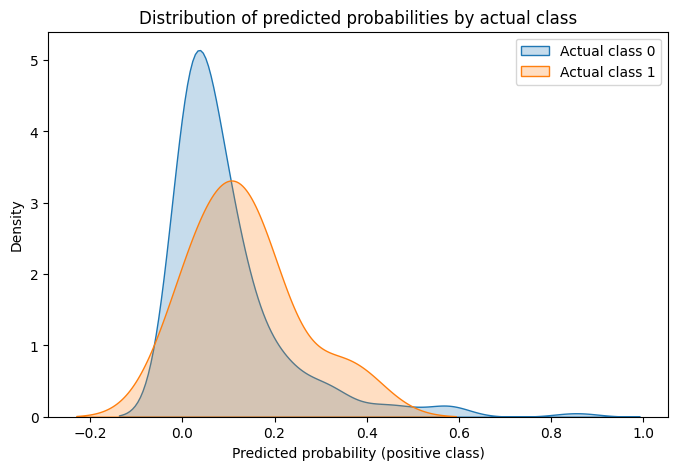

In [47]:
y_proba = yps[:, 1]

# Combine into one DataFrame for easy plotting
import pandas as pd
df_plot = pd.DataFrame({'y_test': y_test, 'y_proba': y_proba})

# Plot distributions
plt.figure(figsize=(8,5))
sns.kdeplot(data=df_plot[df_plot['y_test'] == 0]['y_proba'], label='Actual class 0', fill=True)
sns.kdeplot(data=df_plot[df_plot['y_test'] == 1]['y_proba'], label='Actual class 1', fill=True)
plt.title("Distribution of predicted probabilities by actual class")
plt.xlabel("Predicted probability (positive class)")
plt.ylabel("Density")
plt.legend()

In [84]:
from imblearn.ensemble import EasyEnsembleClassifier
model = EasyEnsembleClassifier(n_estimators=100,sampling_strategy=0.3,
                              random_state=42, n_jobs=-1)
model.fit(X_train_orig, y_train_orig)
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]

In [85]:
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9701    0.9205    0.9446       176
           1     0.1250    0.2857    0.1739         7

    accuracy                         0.8962       183
   macro avg     0.5475    0.6031    0.5593       183
weighted avg     0.9377    0.8962    0.9151       183



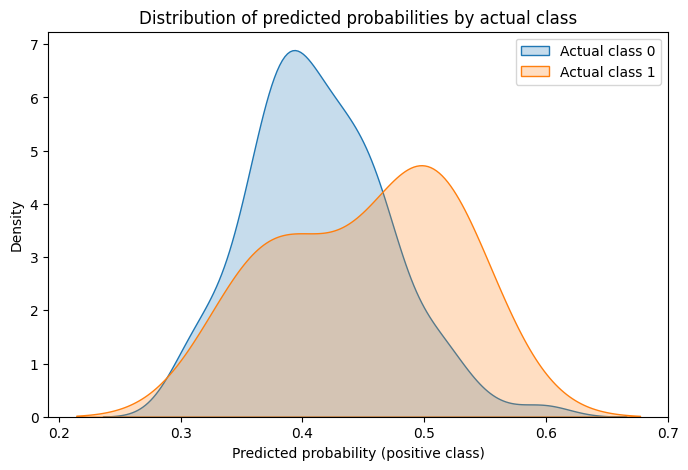

In [86]:
df_plot = pd.DataFrame({'y_test': y_test, 'y_proba': y_proba})

# Plot distributions
plt.figure(figsize=(8,5))
sns.kdeplot(data=df_plot[df_plot['y_test'] == 0]['y_proba'], label='Actual class 0', fill=True)
sns.kdeplot(data=df_plot[df_plot['y_test'] == 1]['y_proba'], label='Actual class 1', fill=True)
plt.title("Distribution of predicted probabilities by actual class")
plt.xlabel("Predicted probability (positive class)")
plt.ylabel("Density")
plt.legend()

In [93]:
%pip install xgboost

   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
   ---------------------------------------- 0.1/72.0 MB 469.7 kB/s eta 0:02:34
   ---------------------------------------- 0.3/72.0 MB 2.0 MB/s eta 0:00:37
   - -------------------------------------- 2.7/72.0 MB 14.3 MB/s eta 0:00:05
   - -------------------------------------- 3.6/72.0 MB 15.1 MB/s eta 0:00:05
   -- ------------------------------------- 4.2/72.0 MB 14.8 MB/s eta 0:00:05
   -- ------------------------------------- 4.6/72.0 MB 14.9 MB/s eta 0:00:05
   -- ------------------------------------- 5.3/72.0 MB 14.7 MB/s eta 0:00:05
   --- ------------------------------------ 6.0/72.0 MB 14.1 MB/s eta 0:00:05
   --- ------------------------------------ 6.5/72.0 MB 14.3 MB/s eta 0:00:05
   --- ------------------------------------ 7.1/72.0 MB 14.2 MB/s eta 0:00:05
   ---- --


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
import numpy as np

# Calculate imbalance ratio
pos = np.sum(y_train_orig == 1)
neg = np.sum(y_train_orig == 0)
scale_pos_weight = neg / pos  # also try tuning around this

xgb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='aucpr',   # use PR-AUC
    n_jobs=-1,
    random_state=42,
    tree_method="hist",    # fast modern tree builder
)

param_distributions = {
    "n_estimators": randint(1000, 10000),
    "learning_rate": uniform(0.01, 0.5),
    "max_depth": randint(3, 20),
    "min_child_weight": randint(1, 10),
    "subsample": uniform(0.6, 0.4),
    "colsample_bytree": uniform(0.1, 0.9),
    "gamma": uniform(0, 5),
    "reg_alpha": uniform(0, 5),
    "reg_lambda": uniform(0, 5),
    "scale_pos_weight": uniform(scale_pos_weight*0.5, scale_pos_weight*1.5)
}

search = RandomizedSearchCV(
    xgb,
    param_distributions=param_distributions,
    n_iter=100,                    # increase to 150 if you have time
    scoring="f2",  # PR-AUC
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1,
)

search.fit(X_train_orig, y_train_orig)

print("Best score:", search.best_score_)
print("Best params:", search.best_params_)

model = search.best_estimator_


Fitting 5 folds for each of 150 candidates, totalling 750 fits


In [102]:
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]

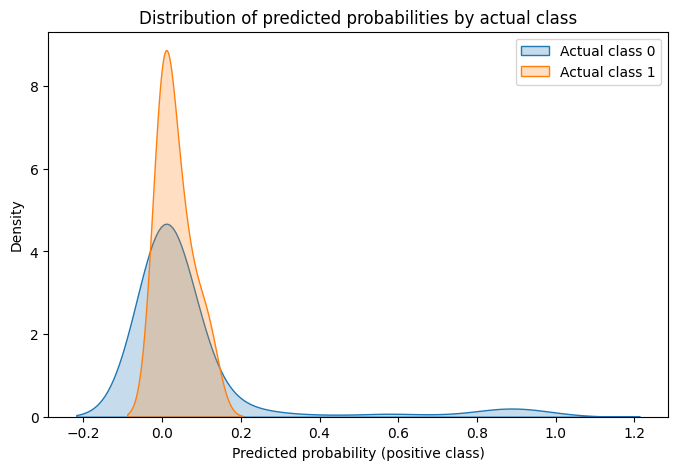

In [103]:
df_plot = pd.DataFrame({'y_test': y_test, 'y_proba': y_proba})

# Plot distributions
plt.figure(figsize=(8,5))
sns.kdeplot(data=df_plot[df_plot['y_test'] == 0]['y_proba'], label='Actual class 0', fill=True)
sns.kdeplot(data=df_plot[df_plot['y_test'] == 1]['y_proba'], label='Actual class 1', fill=True)
plt.title("Distribution of predicted probabilities by actual class")
plt.xlabel("Predicted probability (positive class)")
plt.ylabel("Density")
plt.legend()